<a href="https://colab.research.google.com/github/aplneto/if704-chatbot-project/blob/main/if704_intent_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento dos dados

<!-- https://github.com/awslabs/multi-domain-goal-oriented-dialogues-dataset -->

In [1]:
import numpy as np
import pandas as pd

In [2]:
TRAIN_DATASET = 'https://raw.githubusercontent.com/awslabs/\
multi-domain-goal-oriented-dialogues-dataset/master/data/paper_splits/\
splits_annotated_at_sentence_level/insurance/train.tsv'

TEST_DATASET = 'https://raw.githubusercontent.com/awslabs/\
multi-domain-goal-oriented-dialogues-dataset/master/data/paper_splits/\
splits_annotated_at_sentence_level/insurance/test.tsv'

DEV_DATASET = 'https://raw.githubusercontent.com/awslabs/\
multi-domain-goal-oriented-dialogues-dataset/master/data/paper_splits/\
splits_annotated_at_sentence_level/insurance/dev.tsv'

train_dataset = pd.read_csv(TRAIN_DATASET, sep='\t')
print(len(train_dataset))
train_dataset = train_dataset.append(pd.read_csv(TEST_DATASET, sep='\t'))
print(len(train_dataset))
train_dataset = train_dataset.append(pd.read_csv(DEV_DATASET, sep='\t'))

train_dataset.head()

14498
18605


,conversationId,turnNumber,sentenceNumber,utteranceId,utterance,slot-labels,intent
0,b668a007-9e23-4e4f-8943-e3000cf27efe,1,0,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,good evening sir,O O O,openinggreeting
1,b668a007-9e23-4e4f-8943-e3000cf27efe,1,1,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,i need your help,O O O O,outofdomain
2,b668a007-9e23-4e4f-8943-e3000cf27efe,3,0,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,4523,ssn,contentonly
3,b668a007-9e23-4e4f-8943-e3000cf27efe,4,0,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,tamilarasi k,name name,contentonly
4,b668a007-9e23-4e4f-8943-e3000cf27efe,6,0,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,honda city,car_brand O,contentonly


In [3]:
def normalize_dataset(df):
  useless = df[df.intent.str.contains('<div>')].index
  df = df.drop(useless)
  df['freq'] = (
      df.groupby('intent')['intent'].transform('count') \
      / df.value_counts().sum()
  )**-1
  intents = np.unique(df['intent'])
  sample_size = min(df['intent'].value_counts(normalize=True))*len(intents)*2
  return df.sample(frac=sample_size, weights=df['freq'], replace=True)

In [4]:
print(train_dataset['intent'].value_counts())

contentonly                                 7841
confirmation                                3170
openinggreeting                             2129
thankyou                                    1984
rejection                                   1323
getproofofinsurance                         1292
outofdomain                                 1242
checkclaimstatus                             621
closinggreeting                              606
reportbrokenphone                            435
checkclaimstatus<div>getproofofinsurance       1
Name: intent, dtype: int64


In [5]:
train_dataset = normalize_dataset(train_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [6]:
print(train_dataset['intent'].value_counts())

thankyou               948
confirmation           902
rejection              879
outofdomain            868
getproofofinsurance    868
reportbrokenphone      864
closinggreeting        846
contentonly            838
openinggreeting        835
checkclaimstatus       832
Name: intent, dtype: int64


# Data sampling

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
x = list(train_dataset['utterance'])
for i, sentence in enumerate(x):
  if isinstance(sentence, float):
    x[i] = ''
y = list(train_dataset['intent'])

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
classes = np.unique(y)
tokenizer = Tokenizer(oov_token='<unk>')

tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index

biggest_sequence = max(train_x, key=lambda x: x.split(' ').__len__())
max_len = len(biggest_sequence.split(' '))

train_sequences = tokenizer.texts_to_sequences(train_x)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_x)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')

In [11]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [12]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)

# Transforma em números
train_labels = label_encoder.transform(train_y)
# Transforma a matriz linha em matriz coluna
train_labels = train_labels.reshape(len(train_labels), 1)
# Transforma cada valor em one-hot
train_labels = onehot_encoder.transform(train_labels)

test_labels = label_encoder.transform(test_y)
test_labels = test_labels.reshape(len(test_labels), 1)
test_labels = onehot_encoder.transform(test_labels)

In [13]:
import spacy

In [14]:
nlp = spacy.load('en_core_web_sm')

vocab = [''] + list(tokenizer.word_index.keys())
num_tokens = len(vocab)
vec_dim = len(nlp('the').vector)

embedding_table = np.zeros((num_tokens, vec_dim))


for i, word in enumerate(vocab[1:]):
  embedding_table[i+1] = nlp(word).vector

# Intent Classifier

<!-- https://medium.com/analytics-vidhya/creating-your-own-intent-classifier-b86e000a4926 -->

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, \
Bidirectional, Embedding
from tensorflow.keras.initializers import Constant

In [16]:
model = Sequential()

model.add(
    Embedding(num_tokens, vec_dim, Constant(embedding_table), trainable=False)
)
model.add(
    Bidirectional(
        LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1)
    )
)
model.add(Dropout(0.3))
model.add(
    LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1)
)
model.add(Dropout(0.3))
model.add(Dense(50, 'relu'))
model.add(Dense(classes.shape[0], 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 96)          131616    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         722944    
_________________________________________________________________
dropout (Dropout)            (None, None, 512)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                12850     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [17]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall']
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
history = model.fit(
    train_sequences,
    train_labels,
    epochs = 100,
    batch_size=64,
    shuffle=True,
    callbacks=[EarlyStopping('loss', patience=5)],
    validation_data=[test_sequences, test_labels]
)

Epoch 1/100
95/95 [==============================] - 133s 1s/step - loss: 1.2736 - accuracy: 0.5573 - precision: 0.7855 - recall: 0.4093 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
95/95 [==============================] - 117s 1s/step - loss: 0.6245 - accuracy: 0.8320 - precision: 0.8652 - recall: 0.7913 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
95/95 [==============================] - 117s 1s/step - loss: 0.4984 - accuracy: 0.8728 - precision: 0.8923 - recall: 0.8537 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
95/95 [==============================] - 116s 1s/step - loss: 0.5029 - accuracy: 0.8692 - precision: 0.8910 - recall: 0.8527 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
95/95 [=====================

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

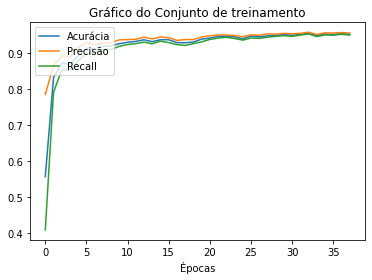

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.title('Gráfico do Conjunto de treinamento')
plt.xlabel('Épocas')
plt.legend(['Acurácia', 'Precisão', 'Recall'], loc='upper left')
plt.show()

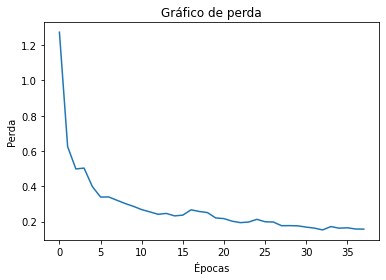

In [22]:
plt.plot(history.history['loss'])
plt.title("Gráfico de perda")
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.show()

In [23]:
from sklearn.metrics import classification_report

In [24]:
pred_y = model.predict(test_sequences)

In [25]:
print(classification_report(np.argmax(test_labels, 1), np.argmax(pred_y, 1)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       222
           1       0.94      0.97      0.95       260
           2       0.90      0.92      0.91       260
           3       0.98      0.73      0.84       264
           4       1.00      0.95      0.97       264
           5       0.97      0.99      0.98       241
           6       0.70      0.82      0.76       251
           7       0.86      0.95      0.90       278
           8       0.95      0.95      0.95       272
           9       0.93      0.90      0.92       292

    accuracy                           0.91      2604
   macro avg       0.92      0.91      0.91      2604
weighted avg       0.92      0.91      0.91      2604



In [26]:
i = np.random.randint(0, len(pred_y)-1)

print(tokenizer.sequences_to_texts([test_sequences[i]]))
print(np.argmax(pred_y[i], -1), np.argmax(test_labels[i], -1))
if np.argmax(pred_y[i], -1) == np.argmax(test_labels[i], -1):
  print(label_encoder.inverse_transform([np.argmax(pred_y[i], -1)]))

['hey there <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>']
5 5
['openinggreeting']


In [27]:
import datetime
import pickle
import os
import pytz
from google.colab import drive

In [28]:
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
proj_directory = '/content/drive/MyDrive/chatbot/'
if not os.path.exists(proj_directory):
  os.mkdir(proj_directory)

model_file = proj_directory + 'intent_classifier'
tokenizer_file = proj_directory + 'tokenizer_intent.pickle'
classes_file = proj_directory + 'classes.pickle'
label_encoder_file = proj_directory + 'label_encoder.pickle'

model.save(model_file)
with open(tokenizer_file, 'wb') as _file:
  pickle.dump(tokenizer, _file)

with open(classes_file, 'wb') as _file:
  pickle.dump(classes, _file)

with open(label_encoder_file, 'wb') as _file:
  pickle.dump(label_encoder, _file)

timestamp = datetime.datetime.now(pytz.timezone('America/Recife'))
print("Last compiled time:", timestamp)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/chatbot/intent_classifier/assets
Last compiled time: 2021-08-22 18:48:25.312866-03:00


* Current best model: 'model_1629590199'

In [30]:
class IntentClassifier(object):
  def __init__(self, classes, model, **kwargs):
    self.classes = classes
    self.classifier = model
    self.tokenizer = kwargs.get('tokenizer')
    self.label_encoder = kwargs.get('label_encoder')
    self.max_len = kwargs.get('max_len', 28)
  
  def __call__(self, text: str):
    sequence = self.tokenizer.texts_to_sequences([text])
    sequence = pad_sequences(sequence, maxlen=self.max_len, padding='post')
    pred = self.classifier(sequence)
    return self.label_encoder.inverse_transform(np.argmax(pred, 1))[0]